<a href="https://www.kaggle.com/code/obisesanelijah/american-housing-analysis?scriptVersionId=182059672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [45]:
# Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap lines
pd.set_option('display.width', 0)  # Automatically adjust the width to the terminal

In [46]:
# Import dataset
df = pd.read_csv('/kaggle/input/american-house-prices-and-demographics-of-top-cities/American_Housing_Data_20231209.csv')

In [47]:
# View the data and check for missing values
print(df.describe().T)
print(df.isna().sum())

                           count           mean            std          min           25%           50%           75%           max
Zip Code                 39981.0   64833.391336   25614.601116  10013.00000   40215.00000   74136.00000   85730.00000  9.819900e+04
Price                    39981.0  622777.118481  946979.305294   1800.00000  265000.00000  399900.00000  674990.00000  3.800000e+07
Beds                     39981.0       3.171682       1.308796      1.00000       3.00000       3.00000       4.00000  5.400000e+01
Baths                    39981.0       2.466572       1.323042      1.00000       2.00000       2.00000       3.00000  6.600000e+01
Living Space             39981.0    1901.522723    1211.307257      2.00000    1200.00000    1639.00000    2265.00000  7.434000e+04
Zip Code Population      39981.0   37726.201996   18672.647445      0.00000   24465.00000   35049.00000   46816.00000  1.164690e+05
Zip Code Density         39981.0    2379.412483    2946.574792      0.00000 

In [48]:
# Drop missing values in Median Household Income column
df = df.dropna(subset=['Median Household Income'])

# Drop Latitude and Longitude columns
df.drop(columns=["Latitude", "Longitude"], inplace=True)
print(df.head())

   Zip Code      Price  Beds  Baths  Living Space                Address      City     State  Zip Code Population  Zip Code Density    County  Median Household Income
0     10013  3999000.0     2      3          1967      74 GRAND ST APT 3  New York  New York                29563           20967.9  New York                 370046.0
1     10013  3999000.0     2      3          1967      74 GRAND ST APT 3  New York  New York                29563           20967.9  New York                 370046.0
2     10014  1650000.0     1      1           718  140 CHARLES ST APT 4D  New York  New York                29815           23740.9  New York                 249880.0
3     10014   760000.0     3      2          1538            38 JONES ST  New York  New York                29815           23740.9  New York                 249880.0
4     10014  1100000.0     1      1           600   81 BEDFORD ST APT 3F  New York  New York                29815           23740.9  New York                 249880.

In [49]:

# 75th percentile
seventy_fifth = df["Price"].quantile(0.75)

# 25th percentile
twenty_fifth = df["Price"].quantile(0.25)

# Interquartile range
prices_iqr = seventy_fifth - twenty_fifth

# Upper threshold
upper = seventy_fifth + (1.5 * prices_iqr)

# Lower threshold
lower = twenty_fifth - (1.5 * prices_iqr)

df_mod = df[(df["Price"] > lower) & (df["Price"] < upper)]
# Compare datasets before and after removing outliers
print(df.describe().T) # Before
print(df_mod.describe().T) # After


                           count           mean            std      min       25%       50%       75%         max
Zip Code                 39979.0   64832.585632   25614.988511  10013.0   40215.0   74136.0   85730.0     98199.0
Price                    39979.0  622782.635233  947002.598473   1800.0  265000.0  399900.0  674990.0  38000000.0
Beds                     39979.0       3.171615       1.308752      1.0       3.0       3.0       4.0        54.0
Baths                    39979.0       2.466520       1.323050      1.0       2.0       2.0       3.0        66.0
Living Space             39979.0    1901.505090    1211.321442      2.0    1200.0    1639.0    2265.0     74340.0
Zip Code Population      39979.0   37728.089297   18671.207769     39.0   24465.0   35049.0   46835.0    116469.0
Zip Code Density         39979.0    2379.531517    2946.600433      0.6     902.4    1588.7    2736.8     58289.6
Median Household Income  39979.0  110837.259861   47309.055715  27475.0   76640.0  10040

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


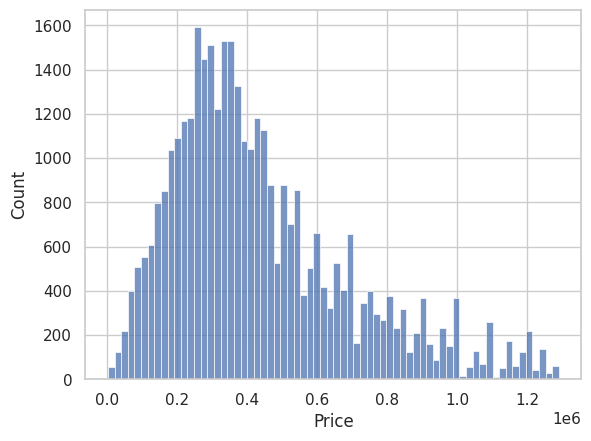

In [50]:
sns.histplot(data=df_mod, x="Price")
plt.show()

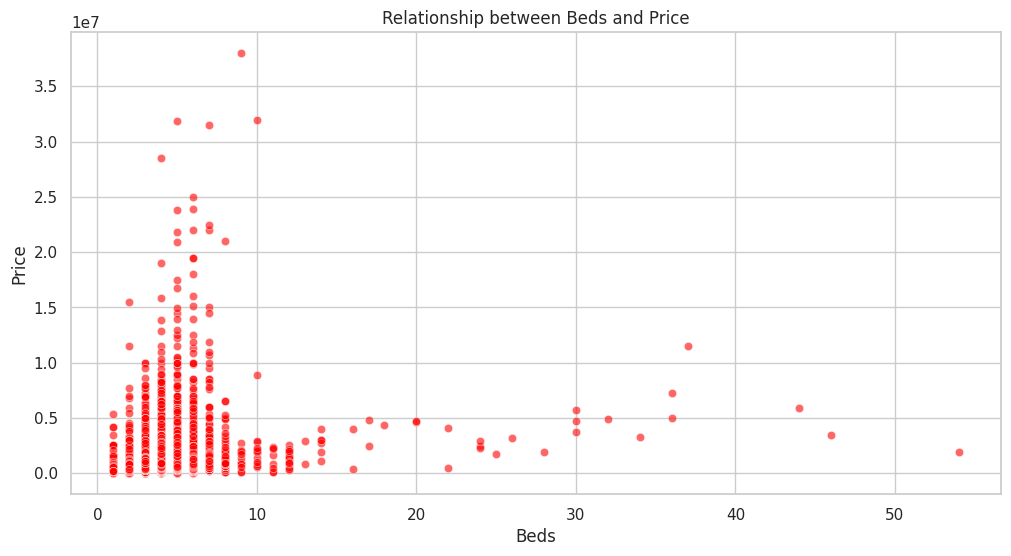

In [51]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Beds', y='Price', data=df, color='red', alpha=0.6,)
plt.title('Relationship between Beds and Price')
plt.xlabel('Beds')
plt.ylabel('Price')
plt.show()


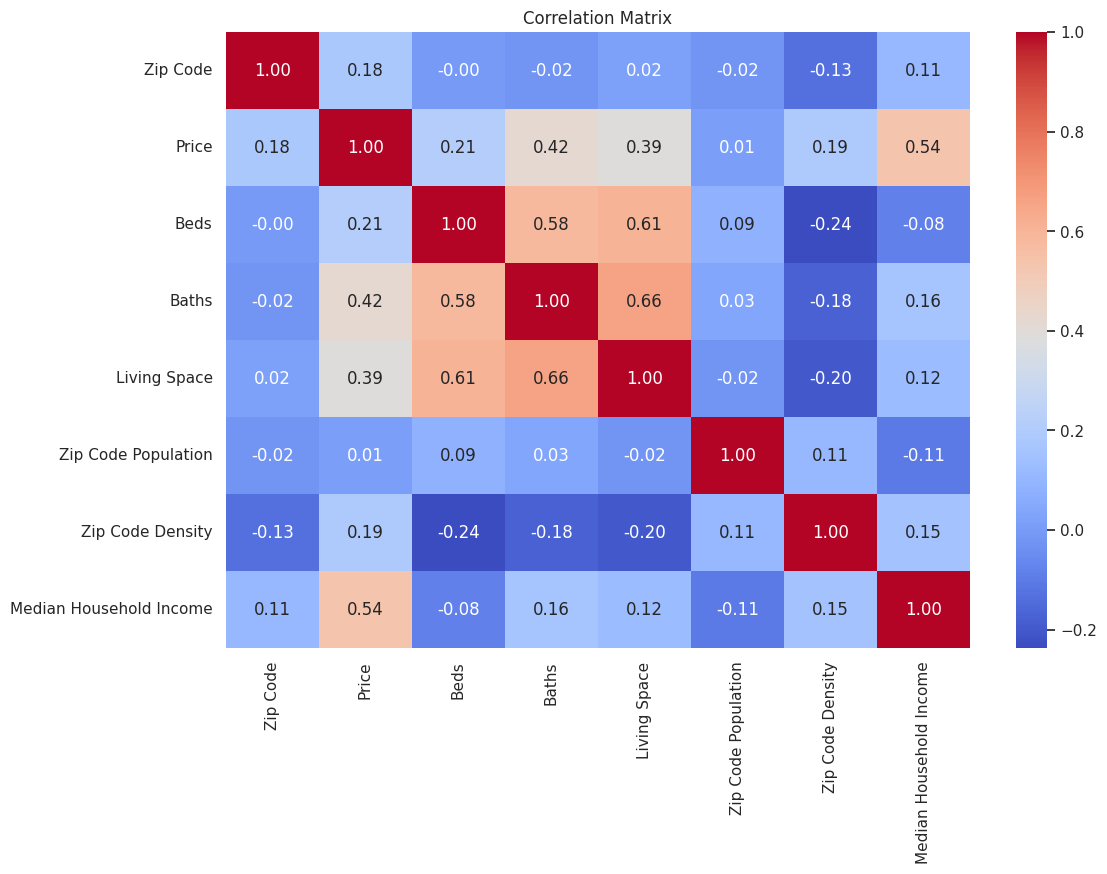

Price                      1.000000
Median Household Income    0.536819
Baths                      0.423280
Living Space               0.389658
Beds                       0.214083
Zip Code Density           0.191775
Zip Code                   0.182455
Zip Code Population        0.013925
Name: Price, dtype: float64


In [52]:
# Check correlation between numerical columns with respect to the each other

# Select only numeric columns
numeric_cols = df_mod.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns
corr_matrix = df_mod[numeric_cols].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values of all features with respect to 'Price'
print(corr_matrix['Price'].sort_values(ascending=False))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

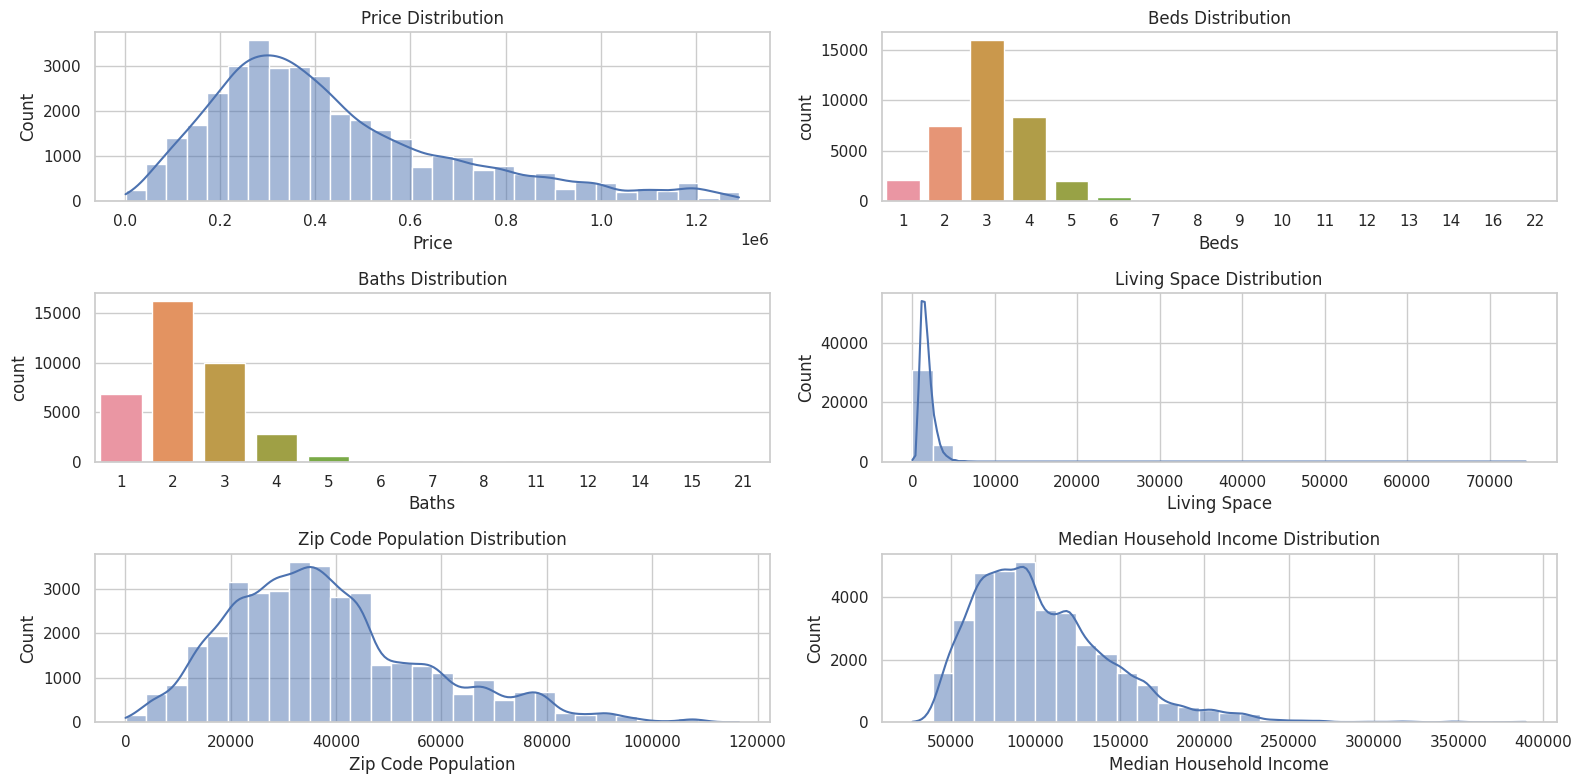

In [66]:
sns.set(style='whitegrid')

fig, axs = plt.subplots(3, 2, figsize=(16, 8))

# Beds distribution
sns.countplot(x='Beds', data=df_mod, ax=axs[0, 1])
axs[0, 1].set_title('Beds Distribution')

# Price distribution
sns.histplot(df_mod['Price'], bins=30, ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Price Distribution')



# Baths distribution
sns.countplot(x='Baths', data=df_mod, ax=axs[1, 0])
axs[1, 0].set_title('Baths Distribution')

# Median Household Income distribution
sns.histplot(df_mod['Median Household Income'], bins=30, ax=axs[2, 1], kde=True)
axs[2, 1].set_title('Median Household Income Distribution')

# Living Space distribution
sns.histplot(df_mod['Living Space'], bins=30, ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Living Space Distribution')

# Zip Code Population distribution
sns.histplot(df_mod['Zip Code Population'], bins=30, ax=axs[2, 0], kde=True)
axs[2, 0].set_title('Zip Code Population Distribution')



plt.tight_layout()
plt.show()

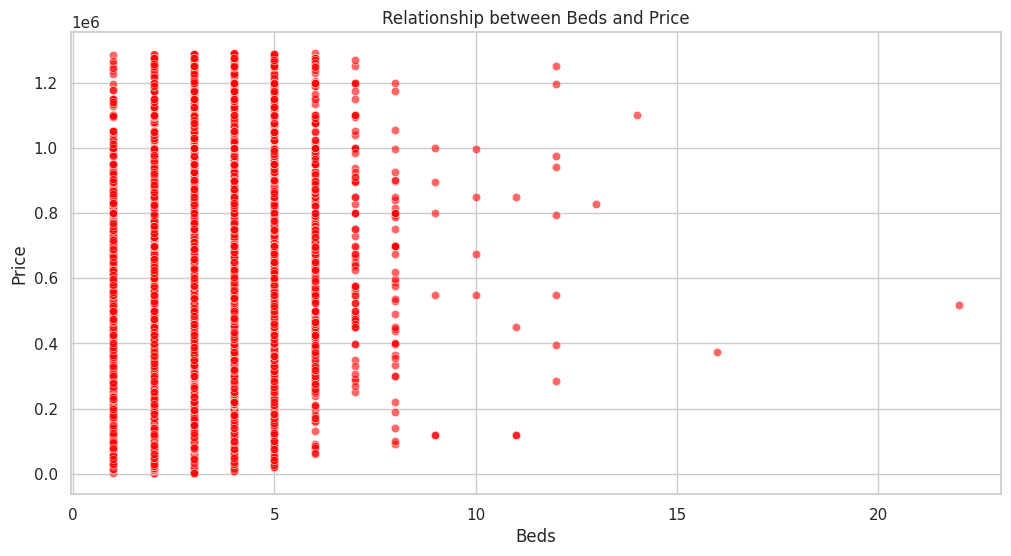

In [54]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Beds', y='Price', data=df_mod, color='red', alpha=0.6,)
plt.title('Relationship between Beds and Price')
plt.xlabel('Beds')
plt.ylabel('Price')
plt.show()


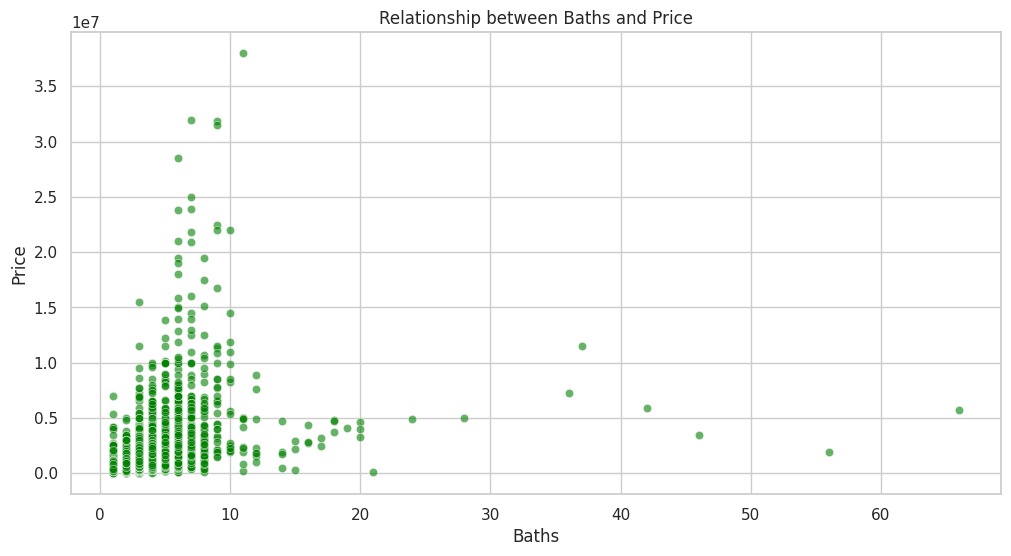

In [55]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Baths', y='Price', data=df, color='green', alpha=0.6)
plt.title('Relationship between Baths and Price')
plt.xlabel('Baths')
plt.ylabel('Price')
plt.show()

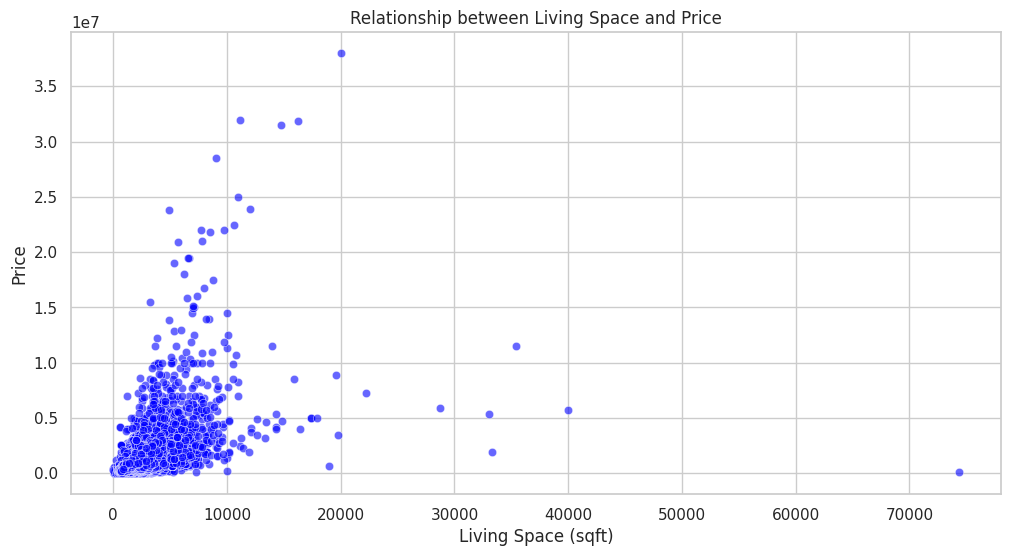

In [56]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Living Space', y='Price', data=df, color='blue', alpha=0.6)
plt.title('Relationship between Living Space and Price')
plt.xlabel('Living Space (sqft)')
plt.ylabel('Price')
plt.show()

In [57]:
expensive_states = df.sort_values(by='Price', ascending=False)

top_10_expensive_states = expensive_states.head(10)

top_10_expensive_states[['State', 'Price']]

,State,Price
32369,California,38000000.0
35645,California,32000000.0
1629,District of Columbia,31900000.0
7665,Florida,31500000.0
32634,California,28500000.0
35741,California,25000000.0
32638,California,23888000.0
33616,California,23800000.0
32672,California,22495000.0
35905,California,22000000.0


In [58]:
expensive_cities = df.sort_values(by='Price', ascending=False)

top_10_expensive_cities = expensive_cities.head(10)

top_10_expensive_cities[['City', 'Price']]

,City,Price
32369,Los Angeles,38000000.0
35645,San Francisco,32000000.0
1629,Washington,31900000.0
7665,Miami,31500000.0
32634,West Hollywood,28500000.0
35741,San Francisco,25000000.0
32638,Los Angeles,23888000.0
33616,La Jolla,23800000.0
32672,Pacific Palisades,22495000.0
35905,San Francisco,22000000.0


In [59]:
cheap_states = df.sort_values(by='Price', ascending=False)

top_10_cheap_states = expensive_cities.tail(10)

top_10_cheap_states[['State', 'Price']]

,State,Price
298,New York,3000.0
322,New York,2750.0
330,New York,2500.0
69,New York,2500.0
306,New York,2500.0
112,New York,2200.0
18133,Louisiana,2000.0
34393,California,1995.0
7928,Florida,1950.0
94,New York,1800.0


In [60]:
cheap_cities = df.sort_values(by='Price', ascending=False)

top_10_cheap_cities = expensive_cities.tail(10)

top_10_cheap_cities[['City', 'Price']]

,City,Price
298,Brooklyn,3000.0
322,Brooklyn,2750.0
330,Brooklyn,2500.0
69,Staten Island,2500.0
306,Brooklyn,2500.0
112,Staten Island,2200.0
18133,New Orleans,2000.0
34393,Fresno,1995.0
7928,Miami,1950.0
94,Staten Island,1800.0


In [61]:
# Details of the most expensive house

# Index of the row with the highest price
max_price_index = df_mod['Price'].idxmax()

# Print the row with the highest price
max_price_row = df_mod.loc[max_price_index]
print(max_price_row)

Zip Code                            98119
Price                           1289950.0
Beds                                    4
Baths                                   2
Living Space                         2050
Address                    2704 9TH AVE W
City                              Seattle
State                          Washington
Zip Code Population                 26094
Zip Code Density                   4186.5
County                               King
Median Household Income          170519.0
Name: 39626, dtype: object


In [62]:
# Details of the most expensive house

# Index of the row with the highest price
max_price_index = df_mod['Price'].idxmin()

# Print the row with the highest price
max_price_row = df_mod.loc[max_price_index]
print(max_price_row)

Zip Code                               10308
Price                                 1800.0
Beds                                       1
Baths                                      1
Living Space                             700
Address                    369 KATAN AVE # 1
City                           Staten Island
State                               New York
Zip Code Population                    30353
Zip Code Density                      5362.7
County                              Richmond
Median Household Income             136486.0
Name: 94, dtype: object


In [63]:
# Define the scaler for normalization
scaler = MinMaxScaler(feature_range=(0, 1))

# Define features and target variable
features = ['Beds', 'Baths', 'Living Space', 'City', 'State', 'Zip Code Population', 'Zip Code Density', 'Median Household Income']
target = 'Price'

# Load data
X = df_mod[features]
y = df_mod[target]

In [64]:
# Define numerical and categorical features
numeric_features = ['Beds', 'Baths', 'Living Space', 'Zip Code Population', 'Zip Code Density', 'Median Household Income']
categorical_features = ['City', 'State']

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Fit the preprocessor on training data and transform both training and testing data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define and fit the linear regression model
model = LinearRegression()
model.fit(X_train_transformed, y_train)

# Make predictions on the testing set
predicted = model.predict(X_test_transformed)

# Print the first 10 predictions and their corresponding features and actual values
for i in range(10):
    print(f"Predicted: {predicted[i]}, Features: {X_test.iloc[i].tolist()}, Actual: {y_test.iloc[i]}")

Predicted: 159057.67832551576, Features: [3, 1, 1080, 'Columbus', 'Ohio', 46038, 768.8, 67173.0], Actual: 234900.0
Predicted: 596761.2051480379, Features: [1, 1, 630, 'Seattle', 'Washington', 52210, 4397.0, 167932.0], Actual: 379900.0
Predicted: 251792.9491042148, Features: [4, 2, 1968, 'Kansas City', 'Kansas', 30874, 1038.0, 61534.0], Actual: 240000.0
Predicted: 260995.10124525905, Features: [3, 2, 1160, 'Philadelphia', 'Pennsylvania', 45642, 9964.3, 58668.0], Actual: 155000.0
Predicted: 753299.242724653, Features: [3, 2, 1572, 'Nashville', 'Tennessee', 6481, 324.5, 230199.0], Actual: 649900.0
Predicted: 417880.98426270054, Features: [4, 3, 1800, 'Philadelphia', 'Pennsylvania', 38840, 2147.0, 107171.0], Actual: 419900.0
Predicted: 267464.92436558986, Features: [3, 2, 1249, 'Edmond', 'Oklahoma', 42003, 476.0, 140148.0], Actual: 256990.0
Predicted: 673486.6489575207, Features: [5, 4, 3125, 'Manor', 'Texas', 30955, 113.5, 104187.0], Actual: 527653.0
Predicted: 162715.22259995047, Feature